In [12]:
from glob import glob

import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as pltdates
from matplotlib import colors as pltcolors
from datetime import datetime as dt

In [26]:
from numba import njit
@njit
def identify_side_jit(dts, lons, lats, tfm_times, seabreeze, grid_lon, grid_lat):
    seabreezes = np.zeros(lons.shape)
    for i in np.arange(seabreezes.shape[0]):
        lon = lons[i]
        lat = lats[i]
        this_dt = dts[i]
        closest_time_idx = np.argmin(np.abs(tfm_times - this_dt))
        dist_idx_raveled = np.argmin(((grid_lon - lon)**2 + (grid_lat - lat)**2)**0.5)
        # dist_idx = np.unravel_index(distance.compute(), distance.shape)
        # Manually implement unravel_index since it isn't supported by numba
        closest_row_idx = dist_idx_raveled // grid_lon.shape[1]
        closest_col_idx = dist_idx_raveled % grid_lon.shape[1]
        closest_seabreeze = seabreeze[closest_time_idx, closest_row_idx, closest_col_idx]
        seabreezes[i] = closest_seabreeze
    return seabreezes

def identify_side(dts, lons, lats, tfm):
    seabreezes = np.zeros(lons.shape)
    for i in np.arange(seabreezes.shape[0]):
        lon = lons[i]
        lat = lats[i]
        this_dt = dts[i]
        tfm_time = tfm.sel(time=this_dt, method='nearest')
        distance = (((tfm_time.lon - lon)**2 + (tfm_time.lat - lat)**2)**0.5)
        dist_idx = np.unravel_index(distance.argmin().compute(), distance.shape)
        closest_seabreeze = tfm_time.seabreeze.transpose(*tfm_time.lat.dims).data[dist_idx].compute()
        seabreezes[i] = closest_seabreeze
    return seabreezes

In [15]:
date_i_want = dt(2022, 6, 2)

In [3]:
tfm_path = f'/Volumes/LtgSSD/tobac_saves/tobac_Save_{date_i_want.strftime("%Y%m%d")}/seabreeze-obs.zarr'
tfm = xr.open_dataset(tfm_path, engine='zarr', chunks='auto')
tfm

<xarray.Dataset> Size: 5GB
Dimensions:                           (feature: 16210, cell: 945, time: 283,
                                       vertical_levels: 2000, x: 1001, y: 1001,
                                       track: 770)
Coordinates:
  * cell                              (cell) int64 8kB -1 4 6 ... 5092 5107 5110
  * feature                           (feature) int64 130kB 1 2 ... 16209 16210
  * time                              (time) datetime64[ns] 2kB 2022-06-02T00...
  * track                             (track) float64 6kB 0.0 1.0 ... 769.0
  * vertical_levels                   (vertical_levels) int64 16kB 0 1 ... 1999
  * x                                 (x) float64 8kB -2.5e+05 ... 2.5e+05
  * y                                 (y) float64 8kB -2.5e+05 ... 2.5e+05
Data variables: (12/63)
    avg_L2-MCMIPC                     (feature) float64 130kB dask.array<chunksize=(16210,), meta=np.ndarray>
    cell_child_feature_count          (cell) float64 8kB dask.array<chunksize=(945,), meta=np.ndarray>
    cell_parent_track_id              (cell) float64 8kB dask.array<chunksize=(945,), meta=np.ndarray>
    continental_dewpoint_profile      (time, vertical_levels) float64 5MB dask.array<chunksize=(283, 2000), meta=np.ndarray>
    continental_msl_profile           (time, vertical_levels) float64 5MB dask.array<chunksize=(283, 2000), meta=np.ndarray>
    continental_pressure_profile      (time, vertical_levels) float64 5MB dask.array<chunksize=(283, 2000), meta=np.ndarray>
    ...                                ...
    min_L2-MCMIPC                     (feature) float64 130kB dask.array<chunksize=(16210,), meta=np.ndarray>
    seabreeze                         (time, y, x) int64 2GB dask.array<chunksize=(224, 273, 273), meta=np.ndarray>
    segmentation_mask                 (time, y, x) float32 1GB dask.array<chunksize=(283, 344, 344), meta=np.ndarray>
    segmentation_mask_cell            (time, y, x) float32 1GB dask.array<chunksize=(283, 344, 344), meta=np.ndarray>
    std_L2-MCMIPC                     (feature) float64 130kB dask.array<chunksize=(16210,), meta=np.ndarray>
    track_child_cell_count            (track) float64 6kB dask.array<chunksize=(770,), meta=np.ndarray>
Attributes:
    center_lat:      29.47
    center_lon:      -95.08
    soundings_used:  ['housondewnpnM1.b1.20220602.053000.cdf', 'housondewnpnM...

In [4]:
arm_ccn_path = '/Volumes/LtgSSD/arm-ccn-avg/'
arm_ccn_file = glob(arm_ccn_path+date_i_want.strftime('*%Y%m%d*.nc'))[0]
arm_ccn = xr.open_dataset(arm_ccn_file)

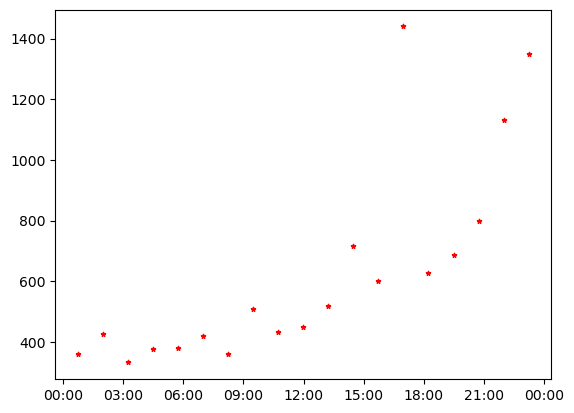

In [5]:
arm_ccn_ccn = arm_ccn.N_CCN.data
arm_ccn_aerosol = arm_ccn.aerosol_number_concentration
arm_ccn_time = arm_ccn.time.data
readings_in_window = ((arm_ccn.supersaturation_calculated >= 0.35) & (arm_ccn.supersaturation_calculated <= 0.55))
arm_ccn_ccn_window = arm_ccn_ccn[readings_in_window]
arm_ccn_aerosol_window = arm_ccn_aerosol[readings_in_window]
arm_ccn_time_window = arm_ccn_time[readings_in_window]

fig = plt.figure()
ax = fig.gca()

ax.scatter(arm_ccn_time_window, arm_ccn_ccn_window, c='r', s=10, marker='*')

ax.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M'))

(array([19.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 18.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  9., 10.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  8.,  9.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  8.,  6.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  5.,  7.,  4.,  3.]),
 array([0.0822732 , 0.09388115, 0.1054891 , 0.11709706, 0.12870501,
        0.14031297, 0.15192091, 0.16352886, 0.17513682, 0.18674478,
        0.19835272, 0.20996068, 0.22156863, 0.23317657, 0.24478453,
        0.25639248, 0.26800042, 0.27960837, 0.29121634, 0.30282432,
        0.31443226, 0.32604021, 0.33764815, 0.3492561 , 0.36086404,
        0.37247199, 0.38407993, 0.39568794, 0.40729588, 0.41890383,
        0.43051177, 0.4421

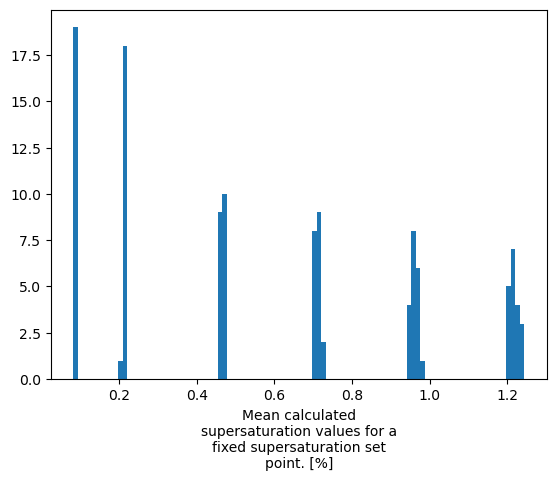

In [6]:
arm_ccn.supersaturation_calculated.plot.hist(bins=100)

In [ ]:
arm_ccn_lon = np.full(arm_ccn_time_window.shape, arm_ccn.lon.data)
arm_ccn_lat = np.full(arm_ccn_time_window.shape, arm_ccn.lat.data)

In [32]:
arm_ccn_sbf_np = np.array(identify_side(arm_ccn_time_window, arm_ccn_lon, arm_ccn_lat, tfm))

In [33]:
arm_ccn_sbf_c = identify_side_jit(arm_ccn_time_window.astype('datetime64[s]').astype(float), arm_ccn_lon, arm_ccn_lat, tfm.time.data.astype('datetime64[s]').astype(float),
                  tfm.seabreeze.transpose('time', *tfm.lon.dims).data.compute(), tfm.lon.data.compute(), tfm.lat.data.compute())

In [42]:
date_i_want = dt(2022, 7, 13)
tamu_ccn_path = '/Volumes/LtgSSD/brooks-ccn/'
tamu_ccn_file = glob(tamu_ccn_path+date_i_want.strftime('*%y%m%d_ccn*.csv'))[0]

In [43]:
tamu_ccn = pd.read_csv(tamu_ccn_file)

In [44]:
tamu_ccn = tamu_ccn[tamu_ccn['SS'] == 0.4].reset_index(drop=True)

In [48]:
tamu_times_window = pd.to_datetime(tamu_ccn.loc[:, 'Time'], format='%y%m%d %H:%M:%S').values
tamu_ccn_window = tamu_ccn.loc[:, 'N_CCN'].values
tamu_ccn_lon_window = tamu_ccn.loc[:, 'Longitude'].values
tamu_ccn_lat_window = tamu_ccn.loc[:, 'Latitude'].values
tamu_ccn_sbf = identify_side(tamu_times_window, tamu_ccn_lon_window, tamu_ccn_lat_window, tfm)

In [51]:
tamu_ccn_sbf

array([-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2

In [52]:
tamu_ccn_sbf = identify_side_jit(tamu_times_window.astype('datetime64[s]').astype(float), tamu_ccn_lon_window, tamu_ccn_lat_window,
                                 tfm.time.data.astype('datetime64[s]').astype(float), tfm.seabreeze.transpose('time', *tfm.lon.dims).data.compute(), tfm.lon.data.compute(), tfm.lat.data.compute())

In [53]:
tamu_ccn_sbf

array([-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2

In [54]:
tfm

<xarray.Dataset> Size: 5GB
Dimensions:                           (feature: 16210, cell: 945, time: 283,
                                       vertical_levels: 2000, x: 1001, y: 1001,
                                       track: 770)
Coordinates:
  * cell                              (cell) int64 8kB -1 4 6 ... 5092 5107 5110
  * feature                           (feature) int64 130kB 1 2 ... 16209 16210
  * time                              (time) datetime64[ns] 2kB 2022-06-02T00...
  * track                             (track) float64 6kB 0.0 1.0 ... 769.0
  * vertical_levels                   (vertical_levels) int64 16kB 0 1 ... 1999
  * x                                 (x) float64 8kB -2.5e+05 ... 2.5e+05
  * y                                 (y) float64 8kB -2.5e+05 ... 2.5e+05
Data variables: (12/63)
    avg_L2-MCMIPC                     (feature) float64 130kB dask.array<chunksize=(16210,), meta=np.ndarray>
    cell_child_feature_count          (cell) float64 8kB dask.array<chunksize=(945,), meta=np.ndarray>
    cell_parent_track_id              (cell) float64 8kB dask.array<chunksize=(945,), meta=np.ndarray>
    continental_dewpoint_profile      (time, vertical_levels) float64 5MB dask.array<chunksize=(283, 2000), meta=np.ndarray>
    continental_msl_profile           (time, vertical_levels) float64 5MB dask.array<chunksize=(283, 2000), meta=np.ndarray>
    continental_pressure_profile      (time, vertical_levels) float64 5MB dask.array<chunksize=(283, 2000), meta=np.ndarray>
    ...                                ...
    min_L2-MCMIPC                     (feature) float64 130kB dask.array<chunksize=(16210,), meta=np.ndarray>
    seabreeze                         (time, y, x) int64 2GB dask.array<chunksize=(224, 273, 273), meta=np.ndarray>
    segmentation_mask                 (time, y, x) float32 1GB dask.array<chunksize=(283, 344, 344), meta=np.ndarray>
    segmentation_mask_cell            (time, y, x) float32 1GB dask.array<chunksize=(283, 344, 344), meta=np.ndarray>
    std_L2-MCMIPC                     (feature) float64 130kB dask.array<chunksize=(16210,), meta=np.ndarray>
    track_child_cell_count            (track) float64 6kB dask.array<chunksize=(770,), meta=np.ndarray>
Attributes:
    center_lat:      29.47
    center_lon:      -95.08
    soundings_used:  ['housondewnpnM1.b1.20220602.053000.cdf', 'housondewnpnM...

Text(0, 0.5, 'count per cm^3')

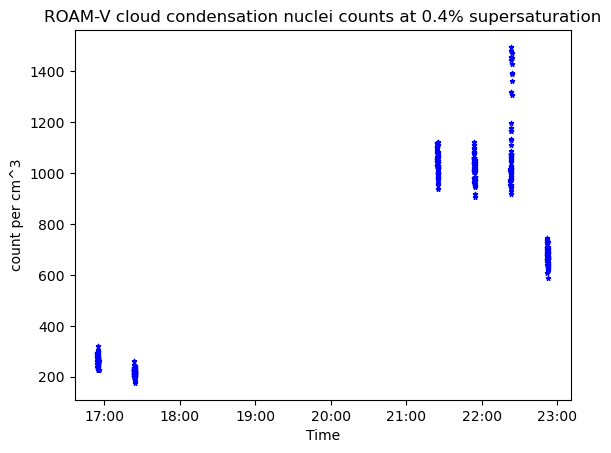

In [11]:
fig = plt.figure()
ax = fig.gca()

ax.scatter(tamu_times_window, tamu_ccn_window, c='b', s=10, marker='*')

ax.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M'))
ax.set_title('ROAM-V cloud condensation nuclei counts at 0.4% supersaturation')
ax.set_xlabel('Time')
ax.set_ylabel('count per cm^3')

In [13]:
ds = xr.open_dataset('/Volumes/LtgSSD/tobac_saves/tobac_Save_20220602/seabreeze-obs.zarr')

/Users/stgardner4/micromamba/envs/tracer/lib/python3.12/site-packages/xarray/backends/plugins.py:149: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/Users/stgardner4/micromamba/envs/tracer/lib/python3.12/site-packages/xarray/backends/plugins.py:149: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/Users/stgardner4/micromamba/envs/tracer/lib/python3.12/site-packages/xarray/backends/plugins.py:149: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [18]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:                           (feature: 16210, cell: 945, time: 283,
                                       vertical_levels: 1000, x: 1001, y: 1001,
                                       track: 770)
Coordinates:
  * cell                              (cell) int64 8kB -1 4 6 ... 5092 5107 5110
  * feature                           (feature) int64 130kB 1 2 ... 16209 16210
  * time                              (time) datetime64[ns] 2kB 2022-06-02T00...
  * track                             (track) float64 6kB 0.0 1.0 ... 769.0
  * vertical_levels                   (vertical_levels) int64 8kB 0 1 ... 999
  * x                                 (x) float64 8kB -2.5e+05 ... 2.5e+05
  * y                                 (y) float64 8kB -2.5e+05 ... 2.5e+05
Data variables: (12/63)
    avg_L2-MCMIPC                     (feature) float64 130kB ...
    cell_child_feature_count          (cell) float64 8kB ...
    cell_parent_track_id              (cell) float64 8kB ...
    continental_dewpoint_profile      (time, vertical_levels) float64 2MB ...
    continental_msl_profile           (time, vertical_levels) float64 2MB ...
    continental_pressure_profile      (time, vertical_levels) float64 2MB ...
    ...                                ...
    min_L2-MCMIPC                     (feature) float64 130kB ...
    seabreeze                         (time, y, x) int64 2GB ...
    segmentation_mask                 (time, y, x) float32 1GB ...
    segmentation_mask_cell            (time, y, x) float32 1GB ...
    std_L2-MCMIPC                     (feature) float64 130kB ...
    track_child_cell_count            (track) float64 6kB 1.0 1.0 ... 1.0 1.0
Attributes:
    center_lat:      29.47
    center_lon:      -95.08
    soundings_used:  ['housondewnpnM1.b1.20220602.053000.cdf', 'housondewnpnM...